<a href="https://colab.research.google.com/github/jixaw31/Image-Classification-model-with-Pytorch-on-FaishonMNIST-dataset/blob/main/GAN_fashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_datasets as tfds


In [2]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete9YMVJS/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete9YMVJS/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
import tensorflow as tf

In [4]:
dataIterator = iter(ds)

# item['image']
# tf.reshape(
#     item['image'], (1, 28, 28)
# ).shape, item['image'].shape


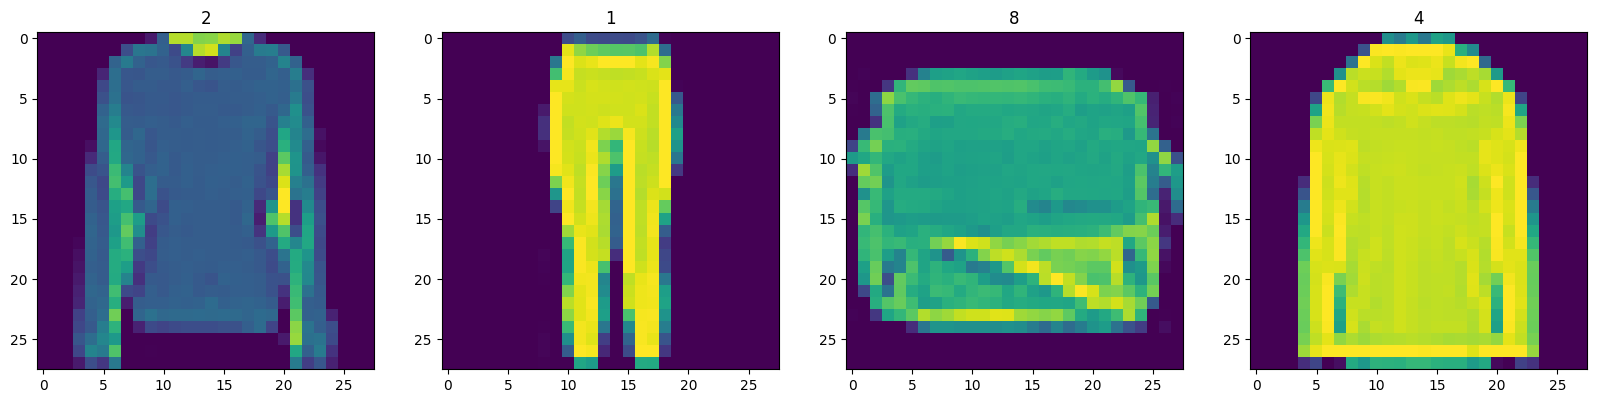

In [5]:
import matplotlib.pyplot as plt, numpy as np
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    batch = dataIterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'].numpy())
plt.show()


In [6]:
# dataIterator = iter(ds)

item = dataIterator.next()
image = item['image']




In [7]:

def scale_image(data):
    image = data['image']
    return image/255

In [8]:
image = ds.as_numpy_iterator().next()
scaled_image = scale_image(image)
scaled_image.shape

(28, 28, 1)

In [9]:
train_ds = ds.map(scale_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(len(train_ds))
train_ds = train_ds.batch(128)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

In [10]:
one_batch = train_ds.as_numpy_iterator().next()

one_batch.shape

(128, 28, 28, 1)

(28, 28, 1)

In [11]:
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, UpSampling2D, Conv2D, Dropout, Flatten
from tensorflow.keras.models import Sequential

In [12]:

def build_generator():
    model = Sequential()

    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # upsampling block
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    #down sampling block
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    #down sampling block
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))


    model.add(Conv2D(1, 5, padding='same', activation='sigmoid'))




    return model

In [13]:
generator = build_generator()
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 0s 377ms/step


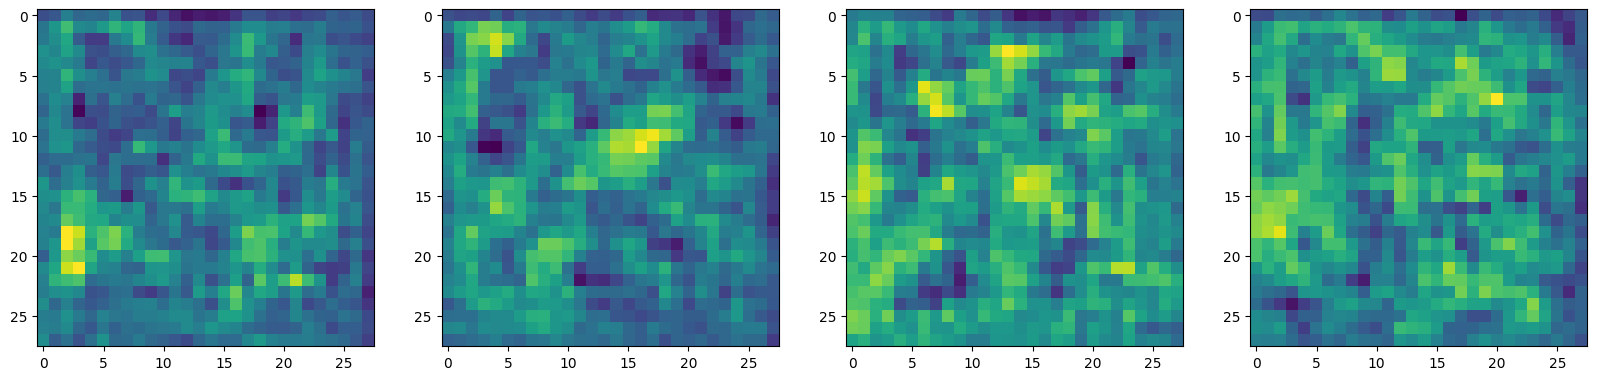

In [14]:
img = generator.predict(np.random.randn(4, 128, 1))



fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
# for idx in range(4):
#     ax[idx].imshow(img[idx])

for idx, image in enumerate(img):
    ax[idx].imshow(image)

plt.show()

In [15]:
def build_discriminator():
    model=Sequential()
    # first conv block
    model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    # second conv block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    # third conv block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    # fourth conv block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten and pass to Dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model



In [55]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)      

In [17]:
img.shape

(4, 28, 28, 1)

In [18]:
discriminator.predict(img)

1/1 [==============================] - 0s 137ms/step


array([[0.49604267],
       [0.49583137],
       [0.49577078],
       [0.4959079 ]], dtype=float32)

**Setting up loss and optimizer**

In [72]:
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers.legacy import Adam

generator_optimizer = Adam(learning_rate=0.0001)
discriminator_optimizer = Adam(learning_rate=0.00001)
# discriminator_optimizer = Adam(learning_rate=0.000033)
generator_loss = BinaryCrossentropy()
discriminator_loss = BinaryCrossentropy()





In [73]:
from tensorflow.keras.models import Model



In [74]:
# tf.random.normal((128, 128, 1))


In [97]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [98]:
# instantiating FashionGAN model
fashGAN = FashionGAN(generator, discriminator)



In [100]:

fashGAN.compile(generator_optimizer,
                 discriminator_optimizer,
                 generator_loss,
                 discriminator_loss,
                 run_eagerly=True)


In [101]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [102]:
class ModelMonitor(Callback):
    def __init__(self, num_img= 3, latent_dim = 128) -> None:
        super().__init__()
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        for i in range (self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/drive/MyDrive/GAN_MNIST/images',
                                  f"generated_img_{epoch}_{i}.png"))


In [ ]:
ds

In [ ]:
len(train_ds.as_numpy_iterator().next())

In [103]:
# recommended epochs : 2000
result = fashGAN.fit(train_ds, epochs=20,
                     callbacks=[ModelMonitor()]
                     )

Epoch 1/20
  5/469 [..............................] - ETA: 4:16:57 - d_loss: 0.6929 - g_loss: 0.6902

KeyboardInterrupt: 